In [103]:
import kagglehub
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd
from networkx.algorithms.community import louvain_communities
from collections import Counter
import re
from collections import defaultdict



# Create graph

In [104]:
df = pd.read_csv("Merged_data.csv")

In [105]:
# Creating the graph
G = nx.Graph()

for i in range(len(df)):
    G.add_node(df['Title'][i],
    release_year = int(df['Released_Year'][i]) if not pd.isna(df['Released_Year'][i]) else None,
    runtime = int((df['Runtime'][i]).replace(' min', '')),
    genre = (df['Genre'][i]).replace(" ", "").split(','),
    imdb_rating = float(df['imdb_rating'][i]),
    description = df['Description'][i],
    director = df['Director'][i],
    stars = [df['Star1'][i], df['Star2'][i], df['Star3'][i], df['Star4'][i]],
    imdb_no_of_votes = int(df['imdb_no_of_votes'][i]),
    gross = int((df['Gross'][i]).replace(',', '')) if not pd.isna(df['Gross'][i]) else None,
    imdb_id = df["imdb_id"][i],
    gl_id = df["gl_id"][i],
    gl_user_id_tags = df["gl_user_id_tags"][i],
    gl_tag = df["gl_tag"][i],
    gl_user_id_ratings = df["gl_user_id_ratings"][i],
    gl_rating = df["gl_rating"][i]
    )

print(G)



Graph with 781 nodes and 0 edges


In [106]:
# Adding edges between movies who share stars
titles = list(df['Title'])
stars_list = df[['Star1', 'Star2', 'Star3', 'Star4']].values.tolist()

for i in range(len(titles)):
    for j in range(i + 1, len(titles)):
        if set(stars_list[i]) & set(stars_list[j]):
            G.add_edge(titles[i], titles[j])

print(G)
print(list(G.degree()))

Graph with 781 nodes and 2423 edges
[('The Shawshank Redemption', 9), ('The Godfather', 19), ('The Dark Knight', 17), ('The Godfather: Part II', 32), ('12 Angry Men', 8), ('The Lord of the Rings: The Return of the King', 10), ('Pulp Fiction', 12), ("Schindler's List", 7), ('Inception', 15), ('Fight Club', 16), ('The Lord of the Rings: The Fellowship of the Ring', 7), ('Forrest Gump', 15), ('The Lord of the Rings: The Two Towers', 10), ('The Matrix', 2), ('Goodfellas', 18), ('Star Wars: Episode V - The Empire Strikes Back', 8), ("One Flew Over the Cuckoo's Nest", 5), ('Hamilton', 0), ('Interstellar', 8), ('Saving Private Ryan', 23), ('The Green Mile', 14), ('Se7en', 20), ('The Silence of the Lambs', 6), ('Star Wars', 12), ("It's a Wonderful Life", 12), ('Joker', 20), ('Whiplash', 4), ('The Intouchables', 0), ('The Prestige', 27), ('The Departed', 26), ('The Pianist', 1), ('Gladiator', 10), ('American History X', 7), ('The Usual Suspects', 6), ('Léon', 8), ('The Lion King', 3), ('Termina

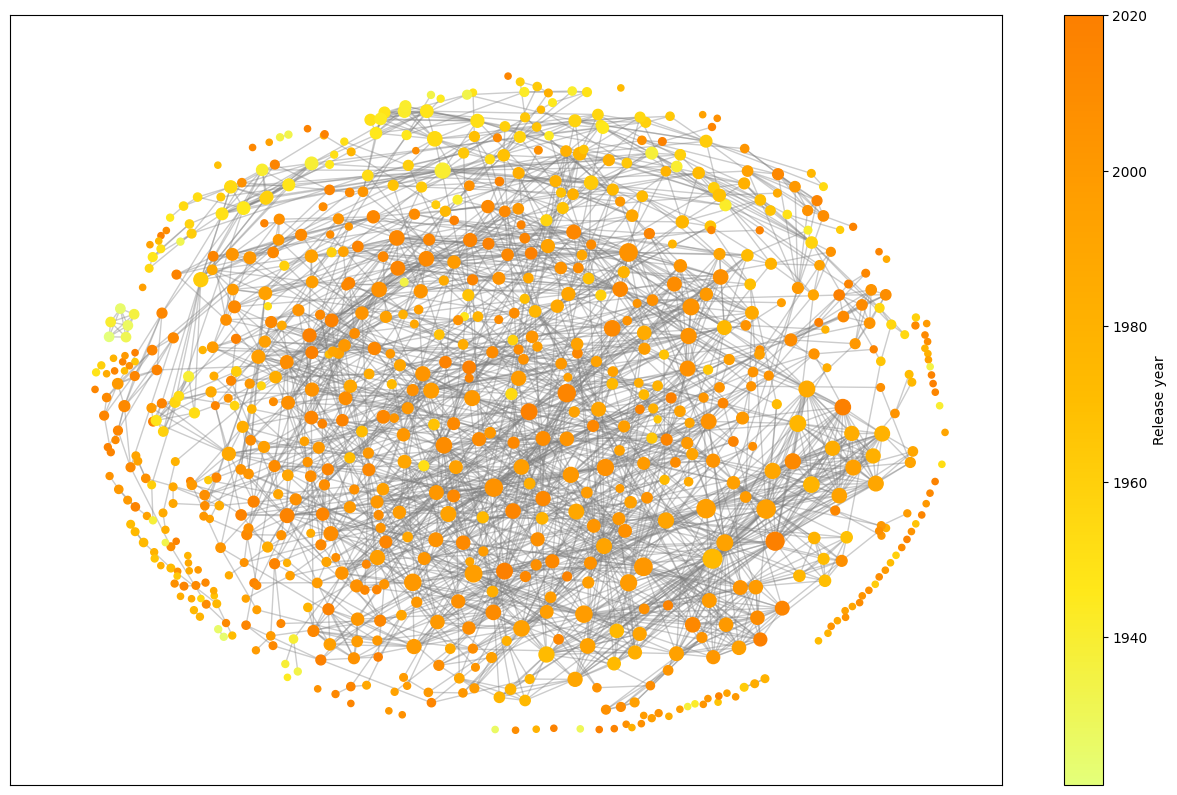

In [107]:
plt.style.use('default')

# Find node size
degrees = dict(G.degree())
node_sizes = [20 + deg * 5 for deg in degrees.values()] 

# Node colors
release_year = nx.get_node_attributes(G, "release_year")
node_colors = [release_year.get(n, 0) for n in G.nodes()]

pos = nx.forceatlas2_layout(G, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Wistia, alpha=1)
nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.4)

# top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:10]
# labels = {n: n for n in top_nodes}
# nx.draw_networkx_labels(G, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Release year")
plt.show()

In [108]:
isolated_nodes = list(nx.isolates(G))
print(f"Number of isolated nodes:", {len(isolated_nodes)})
G_no_isolates = G.copy()
G_no_isolates.remove_nodes_from(isolated_nodes)

Number of isolated nodes: {102}


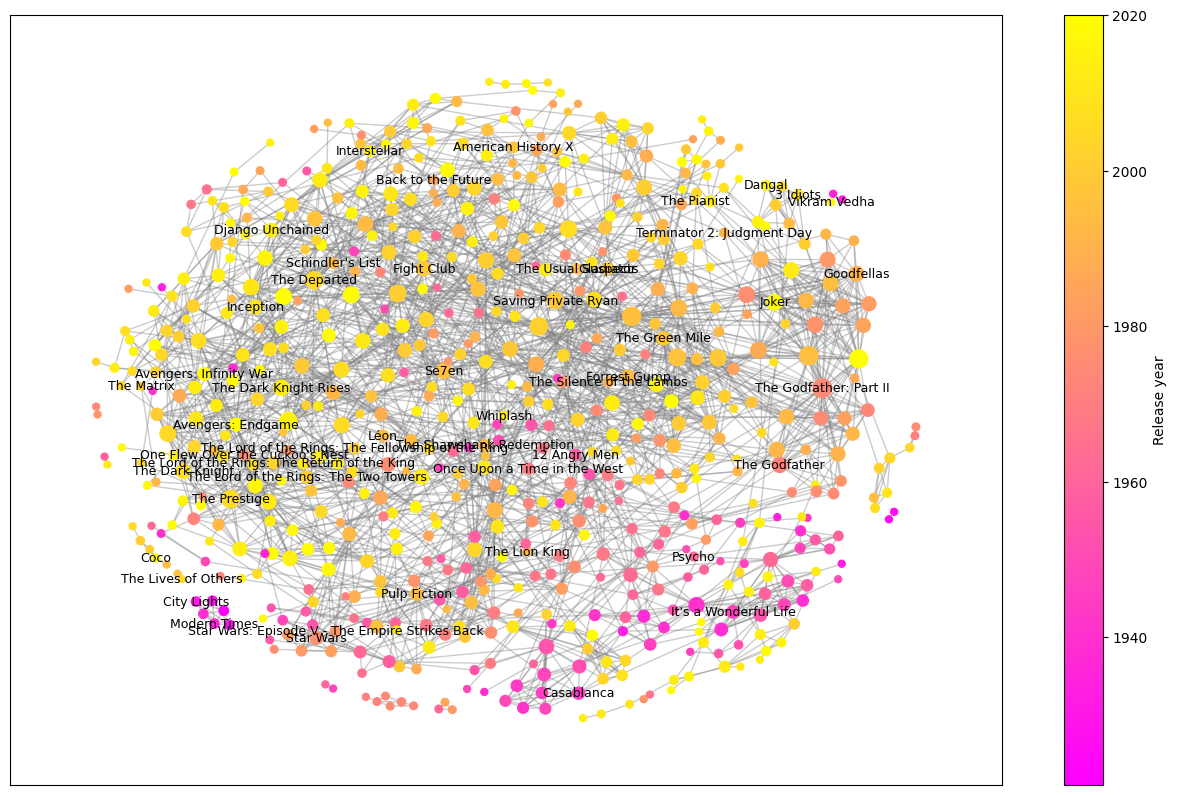

In [109]:
plt.style.use('default')

# # Find node size
degrees = dict(G_no_isolates.degree())
node_sizes = [20 + deg * 5 for deg in degrees.values()] 

# Node colors
release_year = nx.get_node_attributes(G, "release_year")
node_colors = [release_year.get(n, 0) for n in G_no_isolates.nodes()]

pos = nx.forceatlas2_layout(G_no_isolates, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G_no_isolates, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.spring, alpha=1)
nx.draw_networkx_edges(G_no_isolates, pos, edge_color="gray", alpha=0.4)

# top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:10]
# labels = {n: n for n in top_nodes}
# nx.draw_networkx_labels(G_no_isolates, pos, labels, font_size=9, font_weight='normal') 

random_nodes = list(degrees.keys())[:50]
labels = {n: n for n in random_nodes}
nx.draw_networkx_labels(G_no_isolates, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Release year")
plt.show()

In [110]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G_largest = G.subgraph(Gcc[0])
print(G_largest)

Graph with 641 nodes and 2384 edges


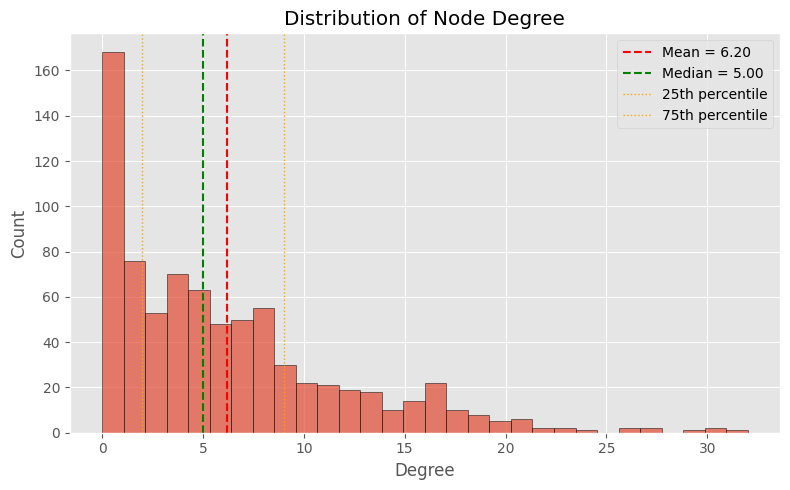

In [111]:
# Degree distribution of original graph

plt.style.use("ggplot")

degree_vals = [deg for _, deg in G.degree()]

mean_deg = np.mean(degree_vals)
median_deg = np.median(degree_vals)
var_deg = np.var(degree_vals)
p25 = np.percentile(degree_vals, 25)
p75 = np.percentile(degree_vals, 75)
min = np.min(degree_vals)
max = np.max(degree_vals)

plt.figure(figsize=(8,5))
plt.hist(degree_vals, bins=30, edgecolor='black', alpha=0.7)

plt.axvline(mean_deg, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean = {mean_deg:.2f}")
plt.axvline(median_deg, color='green', linestyle='dashed', linewidth=1.5, label=f"Median = {median_deg:.2f}")
plt.axvline(p25, color='orange', linestyle='dotted', linewidth=1, label='25th percentile')
plt.axvline(p75, color='orange', linestyle='dotted', linewidth=1, label='75th percentile')

plt.title("Distribution of Node Degree")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

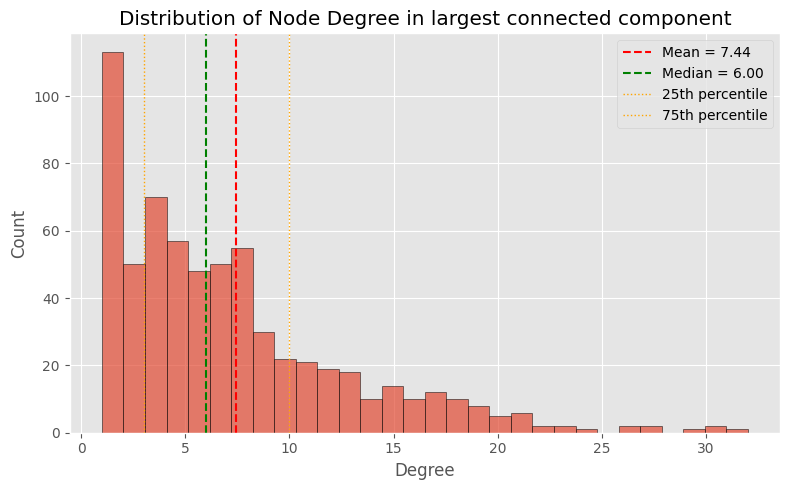

In [112]:
# Degree distribution of largest component

plt.style.use("ggplot")

degree_vals = [deg for _, deg in G_largest.degree()]

mean_deg = np.mean(degree_vals)
median_deg = np.median(degree_vals)
var_deg = np.var(degree_vals)
p25 = np.percentile(degree_vals, 25)
p75 = np.percentile(degree_vals, 75)
min = np.min(degree_vals)
max = np.max(degree_vals)

plt.figure(figsize=(8,5))
plt.hist(degree_vals, bins=30, edgecolor='black', alpha=0.7)

plt.axvline(mean_deg, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean = {mean_deg:.2f}")
plt.axvline(median_deg, color='green', linestyle='dashed', linewidth=1.5, label=f"Median = {median_deg:.2f}")
plt.axvline(p25, color='orange', linestyle='dotted', linewidth=1, label='25th percentile')
plt.axvline(p75, color='orange', linestyle='dotted', linewidth=1, label='75th percentile')

plt.title("Distribution of Node Degree in largest connected component")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

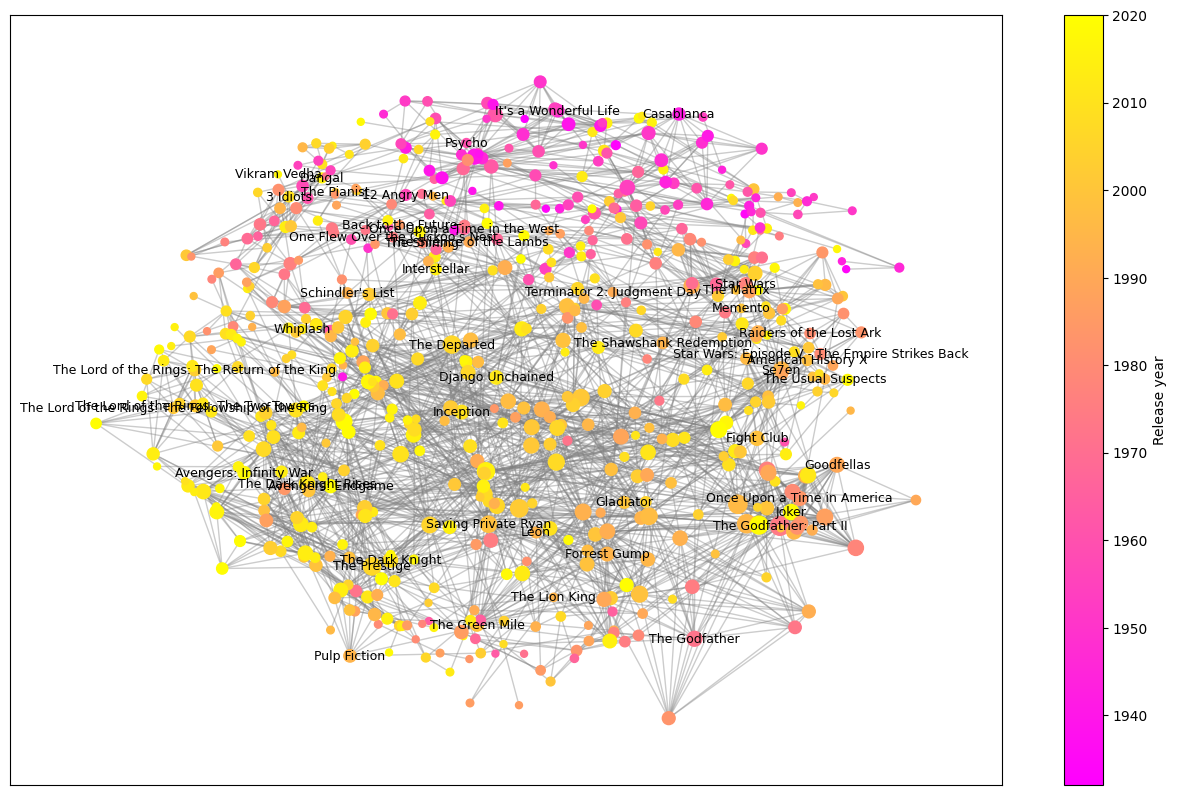

In [113]:
plt.style.use('default')

# # Find node size
degrees = dict(G_largest.degree())
node_sizes = [20 + deg * 5 for deg in degrees.values()] 

# Node colors
release_year = nx.get_node_attributes(G, "release_year")
node_colors = [release_year.get(n, 0) for n in G_largest.nodes()]

pos = nx.forceatlas2_layout(G_largest, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G_largest, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.spring, alpha=1)
nx.draw_networkx_edges(G_largest, pos, edge_color="gray", alpha=0.4)

# top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:10]
# labels = {n: n for n in top_nodes}
# nx.draw_networkx_labels(G_largest, pos, labels, font_size=9, font_weight='normal') 

random_nodes = list(degrees.keys())[:50]
labels = {n: n for n in random_nodes}
nx.draw_networkx_labels(G_largest, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Release year")
plt.show()

In [114]:
# Communities

louv_comm = louvain_communities(G_largest, seed=42)
print(f"Number of communities: {len(louv_comm)}")

M_louvain = nx.community.modularity(G_largest, louv_comm)
print(f"Modularity (Louvain communities): {M_louvain:.4f}")

Number of communities: 15
Modularity (Louvain communities): 0.6818


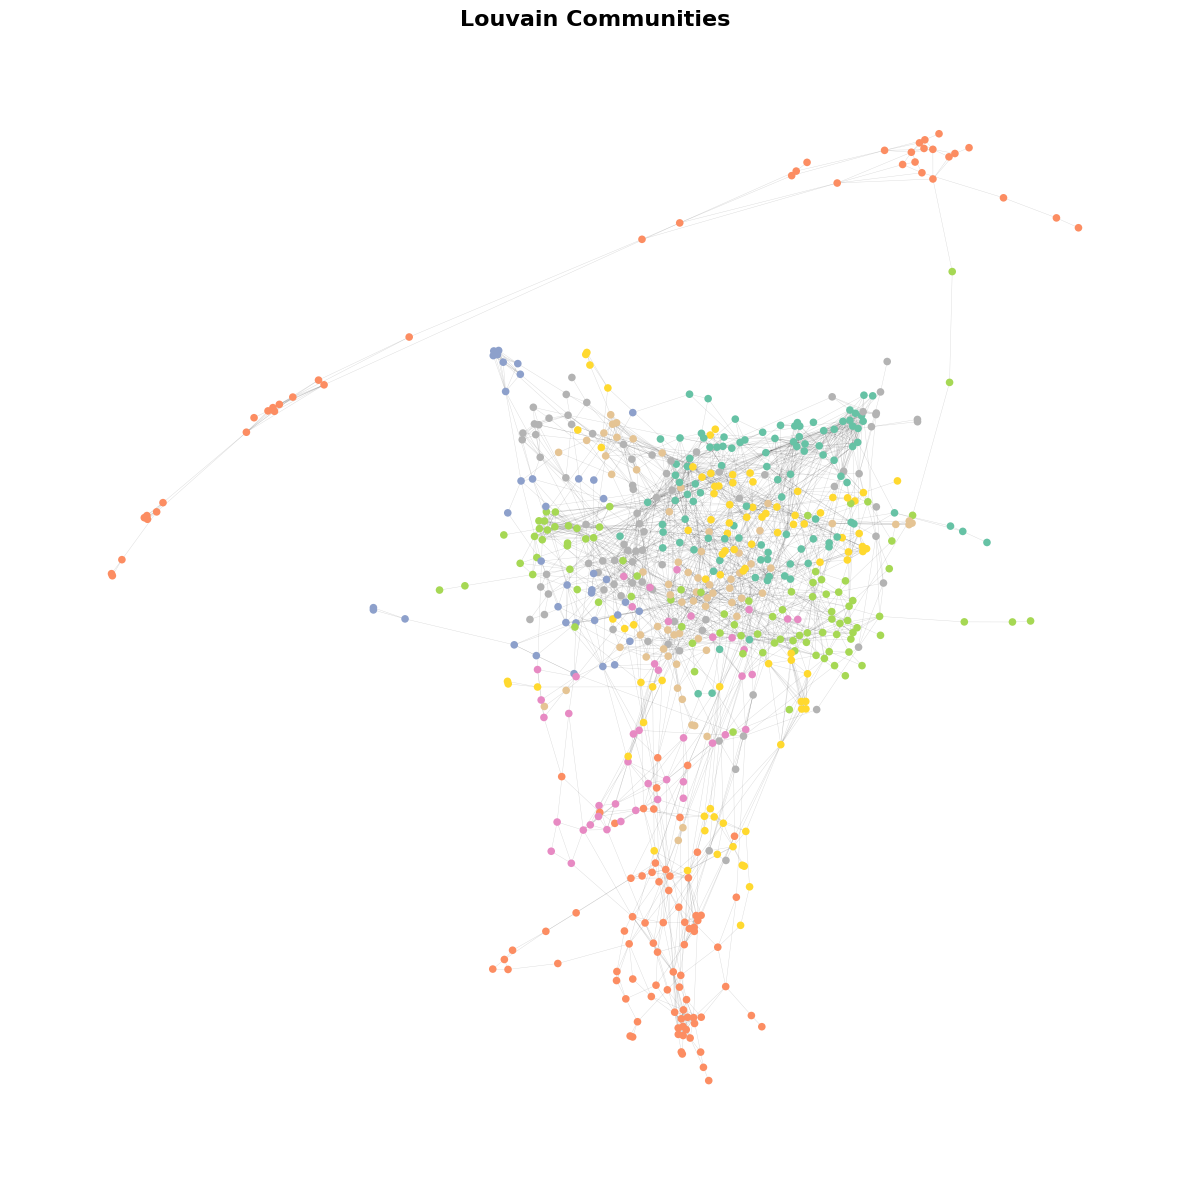

In [115]:
pos = nx.forceatlas2_layout(G, gravity=1.0, seed=42)

top_nodes = set().union(*louv_comm)

# Coloring
colors = plt.cm.Set2(np.linspace(0, 1, len(louv_comm)))
color_map = {}
for i, comm in enumerate(louv_comm):
    for node in comm:
        color_map[node] = colors[i]

node_colors = [color_map.get(n, (0.8, 0.8, 0.8, 0.25)) for n in G_largest.nodes()]

# Plot
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G_largest, pos, alpha=0.15, width=0.3, edge_color="black")
nx.draw_networkx_nodes(
    G_largest,
    pos,
    node_size=30,
    node_color=node_colors,
    linewidths=0.1,
    edgecolors="none",
)
plt.title("Louvain Communities", fontsize=16, fontweight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()

In [116]:
# Community info

deg_cent = nx.degree_centrality(G_largest)

community_info = []

for i, comm in enumerate(louv_comm):
    comm_deg = {n: deg_cent[n] for n in comm}
    top3 = sorted(comm_deg.items(), key=lambda x: x[1], reverse=True)[:3]
    top3_movies = [n.replace("_", " ") for n, _ in top3]

    all_genres = []
    for node in comm:
        g = G_largest.nodes[node].get("genre")
        all_genres.extend(g)
    common_genres = [g for g, _ in Counter(all_genres).most_common(1)]

    community_info.append({
        "Community": f"C{i}",
        "Top movies": ", ".join(top3_movies),
        "Top genres": ", ".join(common_genres),
    })

community_df = pd.DataFrame(community_info)

community_df

Community                                         Top movies Top genres
0         C0            Ocean's Eleven, Se7en, The Big Lebowski      Drama
1         C1             The Godfather: Part II, Sleepers, Heat      Drama
2         C2  The Philadelphia Story, Sabrina, The Man Who S...      Drama
3         C3                     PK, Life of Pi, Dil Chahta Hai      Drama
4         C4         Magnolia, A Few Good Men, Edge of Tomorrow      Drama
5         C5  Harry Potter and the Deathly Hallows: Part 1, ...  Adventure
6         C6  JFK, All the President's Men, Cat on a Hot Tin...      Drama
7         C7  Catch Me If You Can, Saving Private Ryan, Phil...      Drama
8         C8                          Zodiac, The Avengers, Her      Drama
9         C9         Blade Runner 2049, The Fugitive, Star Wars      Drama
10       C10         American Gangster, A Beautiful Mind, Glory      Drama
11       C11  Unforgiven, Million Dollar Baby, Mississippi B...      Drama
12       C12        The Prestige, The Big Short, Ford v Ferrari      Drama
13       C13  The Lion in Winter, The Elephant Man, Guardian...     Action
14       C14  The Departed, Once Upon a Time... in Hollywood...      Drama

In [117]:
# Backbone
def backbone_low_betweenness(G_largest, n_remove):
    # Work on a copy
    Gb = G_largest.copy()

    # Compute edge betweenness
    ebc = nx.edge_betweenness_centrality(Gb)

    # Sort edges: lowest betweenness first
    edges_sorted = sorted(ebc.items(), key=lambda x: x[1])

    # Select lowest n_remove edges
    edges_to_remove = [edge for edge, score in edges_sorted[:n_remove]]

    # Remove edges
    Gb.remove_edges_from(edges_to_remove)

    # Remove isolated nodes
    isolated = list(nx.isolates(Gb))
    Gb.remove_nodes_from(isolated)

    return Gb


# --- Run ---
G_backbone = backbone_low_betweenness(G_largest, n_remove=int(G_largest.number_of_edges()*0.85))


print("Nodes:", G_backbone.number_of_nodes())
print("Edges:", G_backbone.number_of_edges())

Nodes: 316
Edges: 358


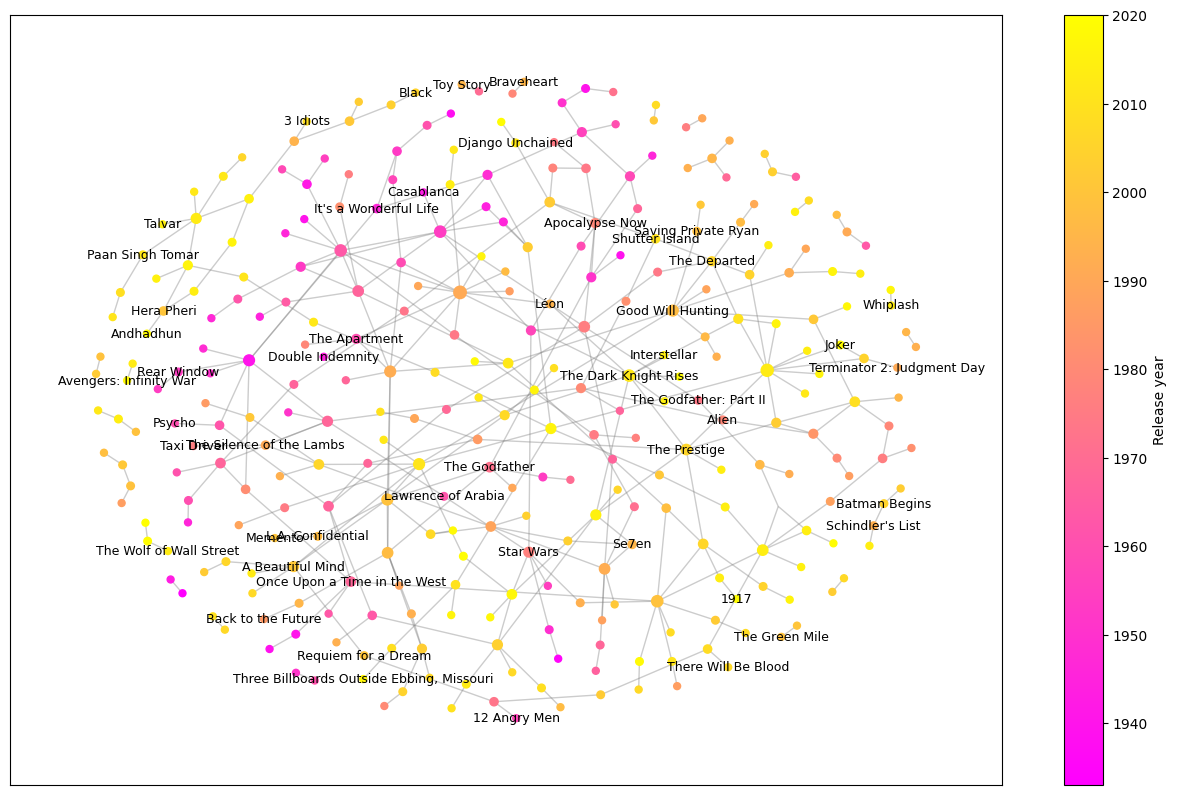

In [118]:
# # Find node size
degrees_backbone = dict(G_backbone.degree())
backbone_node_sizes = [20 + deg * 5 for deg in degrees_backbone.values()]

# Node colors
release_year = nx.get_node_attributes(G_backbone, "release_year")
node_colors = [release_year.get(n, 0) for n in G_backbone.nodes()]

pos = nx.forceatlas2_layout(G_backbone, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G_backbone, pos, node_size=backbone_node_sizes, node_color=node_colors, cmap=plt.cm.spring, alpha=1)
nx.draw_networkx_edges(G_backbone, pos, edge_color="gray", alpha=0.4)

random_nodes = list(degrees_backbone.keys())[:50]
labels = {n: n for n in random_nodes}
nx.draw_networkx_labels(G_backbone, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Release year")
plt.show()

# Create graph connected by 5 star rating

In [127]:
# Creating the graph
G_rating = nx.Graph()

for i in range(len(df)):
    G_rating.add_node(df['Title'][i],
    release_year = int(df['Released_Year'][i]) if not pd.isna(df['Released_Year'][i]) else None,
    runtime = int((df['Runtime'][i]).replace(' min', '')),
    genre = (df['Genre'][i]).replace(" ", "").split(','),
    imdb_rating = float(df['imdb_rating'][i]),
    description = df['Description'][i],
    director = df['Director'][i],
    stars = [df['Star1'][i], df['Star2'][i], df['Star3'][i], df['Star4'][i]],
    imdb_no_of_votes = int(df['imdb_no_of_votes'][i]),
    gross = int((df['Gross'][i]).replace(',', '')) if not pd.isna(df['Gross'][i]) else None,
    imdb_id = df["imdb_id"][i],
    gl_id = df["gl_id"][i],
    gl_user_id_tags = df["gl_user_id_tags"][i],
    gl_tag = df["gl_tag"][i],
    gl_user_id_ratings = df["gl_user_id_ratings"][i],
    gl_rating = df["gl_rating"][i]
    )

print(G_rating)


Graph with 781 nodes and 0 edges


In [128]:
import networkx as nx
from itertools import combinations
from collections import defaultdict
import ast

# Step 1: build mapping user → movies they rated 5
user_movies_5 = defaultdict(list)

for movie in G_rating.nodes:
    users_str = G_rating.nodes[movie]['gl_user_id_ratings']
    ratings_str = G_rating.nodes[movie]['gl_rating']

    # Convert strings to lists if needed
    users = ast.literal_eval(users_str) if isinstance(users_str, str) else users_str
    ratings = ast.literal_eval(ratings_str) if isinstance(ratings_str, str) else ratings_str

    assert len(users) == len(ratings), f"Length mismatch in node {movie}"

    for user, rating in zip(users, ratings):
        if float(rating) >= 5.0:
            user_movies_5[user].append(movie)

# Step 2: count co-rated movie pairs
pair_counts = defaultdict(int)

for movies in user_movies_5.values():
    if len(movies) > 1:
        for m1, m2 in combinations(sorted(movies), 2):  # sort to avoid duplicates
            pair_counts[(m1, m2)] += 1

# Step 3: add edges only if at least 5 users rated both movies 5
for (m1, m2), count in pair_counts.items():
    if count >= 20:
        G_rating.add_edge(m1, m2, weight=count)


In [129]:
print(user_movies_5[5])
print(G_rating)

['Fight Club', 'The Matrix', 'Se7en', 'American Beauty', 'Trainspotting', 'Magnolia', "What's Eating Gilbert Grape"]
Graph with 781 nodes and 174516 edges


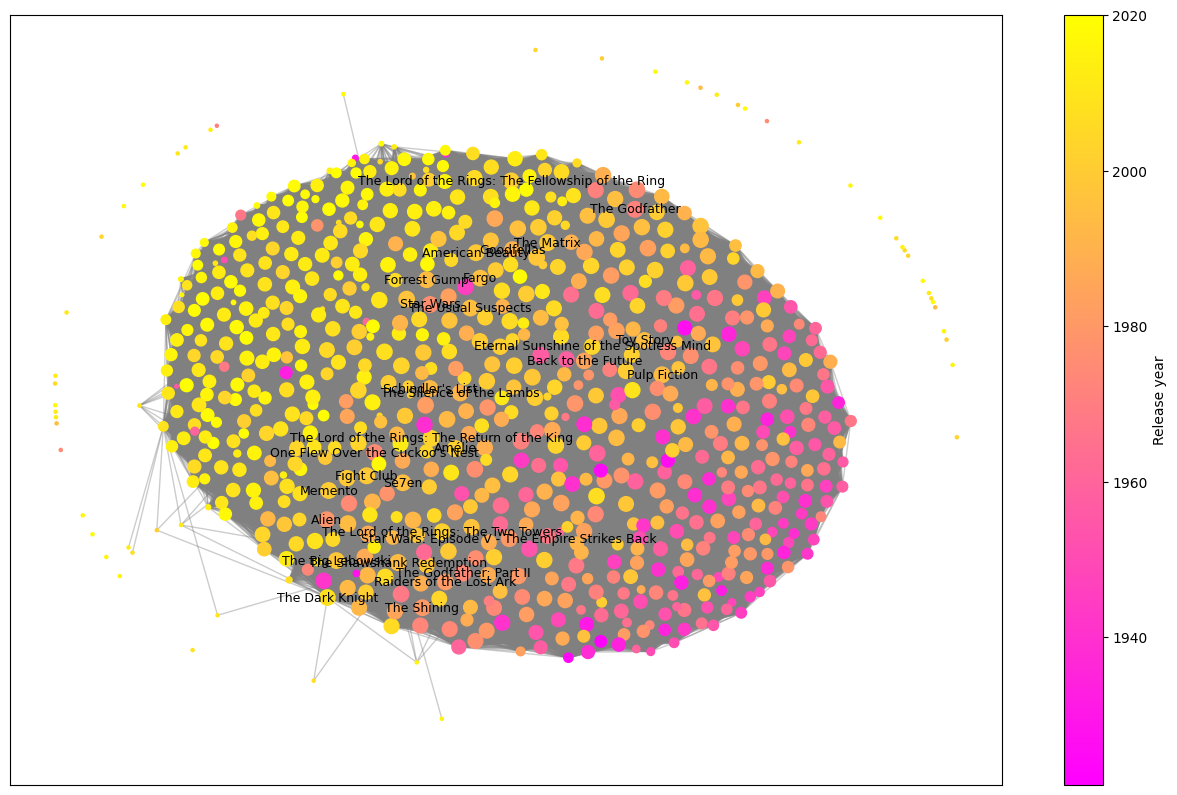

In [148]:
plt.style.use('default')

# Find node size
degrees = dict(G_rating.degree())
node_sizes = [5 + int(deg/6) for deg in degrees.values()] 

# Node colors
release_year = nx.get_node_attributes(G_rating, "release_year")
node_colors = [release_year.get(n, 0) for n in G_rating.nodes()]

pos = nx.forceatlas2_layout(G_rating, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G_rating, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.spring, alpha=1)
nx.draw_networkx_edges(G_rating, pos, edge_color="gray", alpha=0.4)

top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:30]
labels = {n: n for n in top_nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Release year")
plt.show()




In [123]:
print(G_rating.degree())

[('The Shawshank Redemption', 743), ('The Godfather', 739), ('The Dark Knight', 745), ('The Godfather: Part II', 725), ('12 Angry Men', 729), ('The Lord of the Rings: The Return of the King', 736), ('Pulp Fiction', 729), ("Schindler's List", 734), ('Inception', 734), ('Fight Club', 737), ('The Lord of the Rings: The Fellowship of the Ring', 732), ('Forrest Gump', 732), ('The Lord of the Rings: The Two Towers', 734), ('The Matrix', 738), ('Goodfellas', 720), ('Star Wars: Episode V - The Empire Strikes Back', 725), ("One Flew Over the Cuckoo's Nest", 722), ('Hamilton', 439), ('Interstellar', 699), ('Saving Private Ryan', 727), ('The Green Mile', 719), ('Se7en', 729), ('The Silence of the Lambs', 728), ('Star Wars', 725), ("It's a Wonderful Life", 708), ('Joker', 576), ('Whiplash', 696), ('The Intouchables', 654), ('The Prestige', 719), ('The Departed', 728), ('The Pianist', 721), ('Gladiator', 726), ('American History X', 719), ('The Usual Suspects', 728), ('Léon', 722), ('The Lion King'

In [135]:
# Backbone
def backbone_low_betweenness(G_rating, n_remove):
    # Work on a copy
    Gb_rating = G_rating.copy()

    # Compute edge betweenness
    ebc = nx.edge_betweenness_centrality(Gb_rating)

    # Sort edges: lowest betweenness first
    edges_sorted_rating = sorted(ebc.items(), key=lambda x: x[1])

    # Select lowest n_remove edges
    edges_to_remove_rating = [edge for edge, score in edges_sorted_rating[:n_remove]]

    # Remove edges
    Gb_rating.remove_edges_from(edges_to_remove_rating)

    # Remove isolated nodes
    isolated = list(nx.isolates(Gb_rating))
    Gb_rating.remove_nodes_from(isolated)

    return Gb_rating


# --- Run ---
G_backbone_rating = backbone_low_betweenness(G_rating, n_remove=int(G_rating.number_of_edges()*0.995))


print("Nodes:", G_backbone_rating.number_of_nodes())
print("Edges:", G_backbone_rating.number_of_edges())

Nodes: 224
Edges: 873


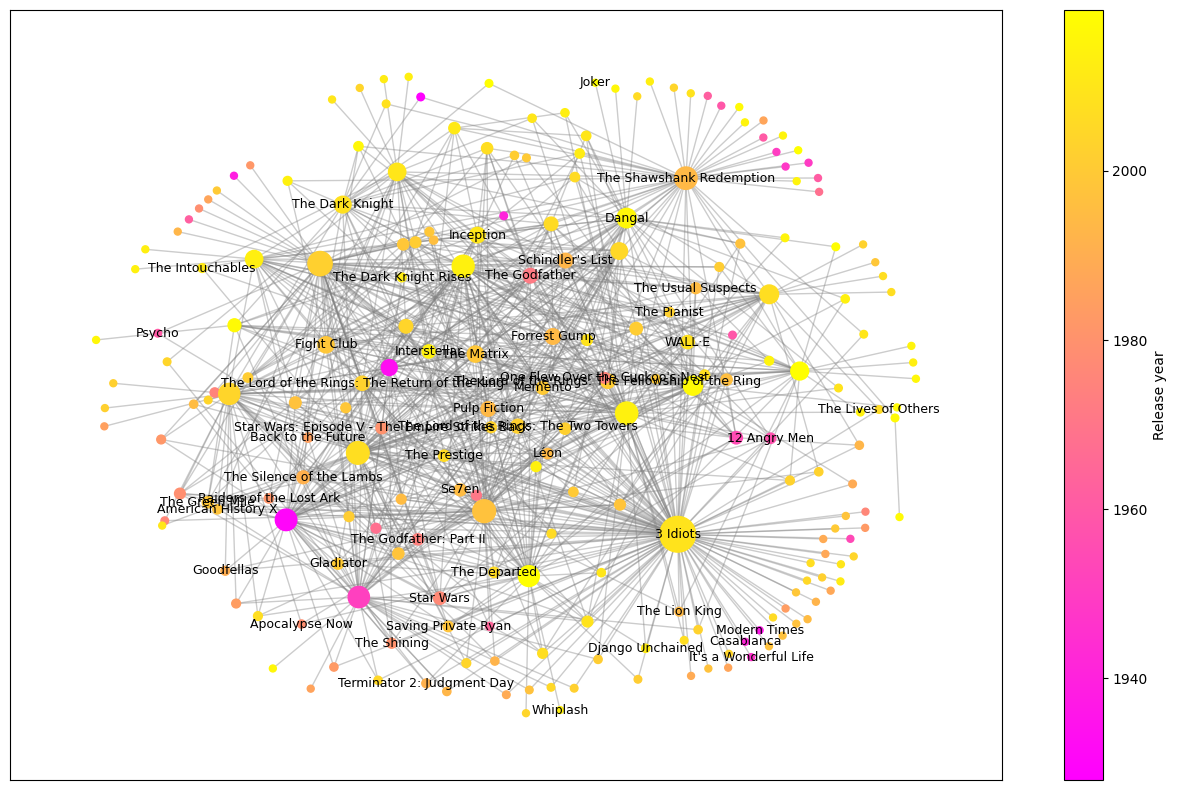

In [136]:
# # Find node size
degrees_backbone_rating = dict(G_backbone_rating.degree())
backbone_node_sizes = [20 + deg * 5 for deg in degrees_backbone_rating.values()]

# Node colors
release_year = nx.get_node_attributes(G_backbone_rating, "release_year")
node_colors = [release_year.get(n, 0) for n in G_backbone_rating.nodes()]

pos = nx.forceatlas2_layout(G_backbone_rating, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G_backbone_rating, pos, node_size=backbone_node_sizes, node_color=node_colors, cmap=plt.cm.spring, alpha=1)
nx.draw_networkx_edges(G_backbone_rating, pos, edge_color="gray", alpha=0.4)

random_nodes = list(degrees_backbone_rating.keys())[:50]
labels = {n: n for n in random_nodes}
nx.draw_networkx_labels(G_backbone_rating, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Release year")
plt.show()

In [ ]:
louv_comm_rating = louvain_communities(G_rating, seed=42)
print(f"Number of communities: {len(louv_comm_rating)}")

M_louvain_rating = nx.community.modularity(G_rating, louv_comm_rating)
print(f"Modularity (Louvain communities): {M_louvain_rating:.4f}")

## Graph statistics

* |V|, |E|, gennemsnitlig grad, gradfordeling (har I næsten)
  * Gennemsnitlig *clustering coefficient* og *diameter / average shortest path* på G_largest.
* *Sammenlign med en random graf (pensum!)*

  * Lav fx en *configuration model* med samme gradsekvens som G_largest.
  * Sammenlign clustering og path length: small-world? mere/ mindre klumpet end forventet?

In [137]:
avg_degree = sum(dict(G_largest.degree()).values()) / G_largest.number_of_nodes()
print("Average degree: ", avg_degree)

n = G_largest.number_of_nodes()
m = G_largest.number_of_edges()
m_valid = round(avg_degree / 2)

G_random = nx.gnm_random_graph(n, m)
G_ba = nx.barabasi_albert_graph(n, m_valid)

avg_shortest_path = nx.average_shortest_path_length(G_largest)
avg_shortest_path_random = nx.average_shortest_path_length(G_random)
avg_shortest_path_ba = nx.average_shortest_path_length(G_ba)

print("Average shortest path: ", avg_shortest_path)
print("Average shortest path random: ", avg_shortest_path_random)
print("Average shortest path scale free: ", avg_shortest_path_ba)

Average degree:  7.438377535101404
Average shortest path:  5.2712851014040565
Average shortest path random:  3.443384360374415
Average shortest path scale free:  3.0431454758190326


Nok ikke small-world giver mening da for at komme fra film i 1940 til film i 2020 er der nok ret langt 

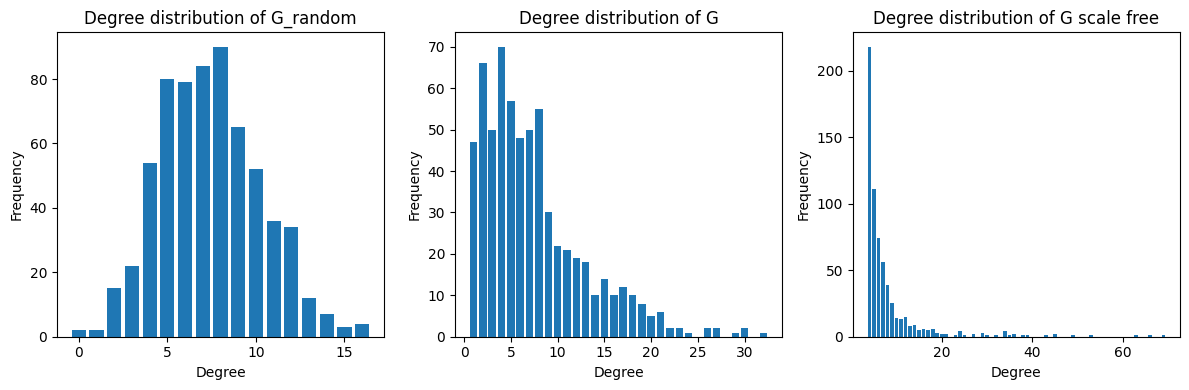

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# -------------------------
# Plot 1 — G_random
# -------------------------
degrees_R = [d for _, d in G_random.degree()]
deg_counts_R = Counter(degrees_R)

x_R = sorted(deg_counts_R.keys())
y_R = [deg_counts_R[k] for k in x_R]

axes[0].bar(x_R, y_R)
axes[0].set_xlabel("Degree")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Degree distribution of G random")

# -------------------------
# Plot 1 — G_ba
# -------------------------
degrees_R = [d for _, d in G_ba.degree()]
deg_counts_R = Counter(degrees_R)

x_R = sorted(deg_counts_R.keys())
y_R = [deg_counts_R[k] for k in x_R]

axes[2].bar(x_R, y_R)
axes[2].set_xlabel("Degree")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Degree distribution of G scale free")

# -------------------------
# Plot 2 — G (original)
# -------------------------
degrees_G = [d for _, d in G_largest.degree()]
deg_counts_G = Counter(degrees_G)

x_G = sorted(deg_counts_G.keys())
y_G = [deg_counts_G[k] for k in x_G]

axes[1].bar(x_G, y_G)
axes[1].set_xlabel("Degree")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Degree distribution of G")

plt.tight_layout()
plt.show()

Tror vi har et sublinear måake alpha mellem 0 og 1 ????

* Beregn fx:

  * *Degree centrality*
  * *Betweenness centrality*
  * Evt. *eigenvector centrality* / *PageRank*
* Undersøg sammenhæng mellem “vigtighed” og metadata:

  * Plot fx degree vs. IMDB-rating
  * Degree vs. antal ratings (fra MovieLens)
  * Er højt-rate­de film også mere “centrale” i cast-netværket?
* Lav evt. en lille top-10 liste over film med højeste centralitet og kommentér, om det giver mening mht. vores intuition om “klassikere”.

In [ ]:
degree_centrality = nx.degree_centrality(G_largest)
betweenness_centrality = nx.betweenness_centrality(G_largest)
eigenvector_centrality = nx.eigenvector_centrality(G_largest)

print(f"Average degree centrality:      {sum(degree_centrality.values())/len(degree_centrality):.4f}")
print(f"Average betweenness centrality: {sum(betweenness_centrality.values())/len(betweenness_centrality):.4f}")
print(f"Average eigenvector centrality: {sum(eigenvector_centrality.values())/len(eigenvector_centrality):.4f}")

assort = nx.degree_assortativity_coefficient(G)
print(f"Degree assortativity: {assort:.4f}")

Average degree centrality:      0.0116
Average betweenness centrality: 0.0067
Average eigenvector centrality: 0.0121
Degree assortativity: 0.4671


Average degree centrality: (node degree) / (maksimal muligt degree).

Average betweenness centrality:  meget lav - derfor de fleste node ligger næsten aldigt på avg shortest path måske få nodes vigtige borer??

Average eigenvector centrality: også lave derfor ingen store hubs mere bredt distribuerert end scale free

Degree assortativity: er positiv og ret høj derfor Høj-degree noder forbinder til andre høj-degree noder. Så de hubs der er det forbinder til de andre hubs



In [163]:
# Sort by value (descending), keep items as (node, value)
top10_betweenness = sorted(betweenness_centrality.items(), 
                           key=lambda x: x[1], 
                           reverse=True)[:10]

print("Top 10 betweenness centrality:")
for node, val in top10_betweenness:
    print(node, val)

print()

top10_eigenvector = sorted(eigenvector_centrality.items(), 
                           key=lambda x: x[1], 
                           reverse=True)[:20]

print("Top 10 eigenvector centrality:")
for node, val in top10_eigenvector:
    print(node, val)

Top 10 betweenness centrality:
Lion 0.13693286825508663
Slumdog Millionaire 0.12554284037558686
Barfi! 0.12282863849765258
Rockstar 0.12010465571205006
Airlift 0.11775397756911841
The Lunchbox 0.08512067777032566
The Girl with the Dragon Tattoo 0.06937262848468431
Her 0.06105373883385468
Bajrangi Bhaijaan 0.05164779184365452
JFK 0.04999810314386965

Top 10 eigenvector centrality:
The Godfather: Part II 0.2713815503334867
The Irishman 0.26948629756974257
Heat 0.2660434579827743
Sleepers 0.2282123715129714
The Deer Hunter 0.213614387481077
Goodfellas 0.20857421875095444
Casino 0.20857421875095444
Raging Bull 0.20857421875095444
The Untouchables 0.20783140853476398
Taxi Driver 0.20759264106382355
Joker 0.20688616696683387
Awakenings 0.20563561257172977
Silver Linings Playbook 0.20487497763211704
A Bronx Tale 0.20344160236007244
Once Upon a Time in America 0.20259824148425656
Brazil 0.20259824148425656
The King of Comedy 0.20259824148425656
Dog Day Afternoon 0.11643838558014818
The Insider

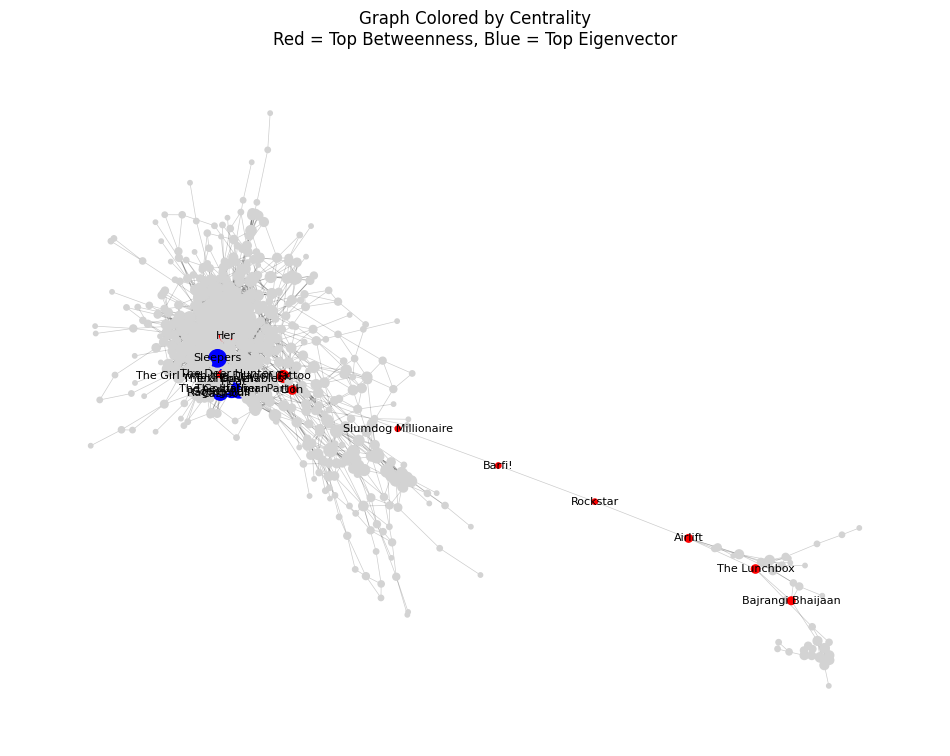

In [159]:
# degrees = dict(G_largest.degree())
# node_sizes = [5 + int(deg/6) for deg in degrees.values()] 

# release_year = nx.get_node_attributes(G_largest, "release_year")
# node_colors = [release_year.get(n, 0) for n in G_largest.nodes()]


# pos = nx.forceatlas2_layout(
#     G_largest, max_iter=500, scaling_ratio=2.0, gravity=1.0,
#     strong_gravity=True, seed=30
# )


# plt.figure(figsize=(16, 10))

# nodes = nx.draw_networkx_nodes(
#     G_largest, pos,
#     node_size=node_sizes,
#     node_color=node_colors,
#     cmap=plt.cm.spring,
#     alpha=1
# )

# nx.draw_networkx_edges(G_largest, pos, edge_color="gray", alpha=0.4)


# top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:30]

# # Color the labels based on centrality category
# label_colors = {}
# for n in top_nodes:
#     if n in top10_betweenness:
#         label_colors[n] = "red"
#     elif n in top10_eigenvector:
#         label_colors[n] = "blue"
#     else:
#         label_colors[n] = "black"

# # Draw labels manually so we can control colors
# for n, (x, y) in pos.items():
#     if n in top_nodes:
#         plt.text(
#             x, y, n,
#             fontsize=9,
#             fontweight="normal",
#             color=label_colors[n]
#         )

# plt.colorbar(nodes, label="Release year")
# plt.title("Movie Network — Node labels colored by centrality\nRed = Betweenness, Blue = Eigenvector")
# plt.axis("off")
# plt.show()

# Extract just the node names
bet_nodes = {node for node, _ in top10_betweenness}
eig_nodes = {node for node, _ in top10_eigenvector}

# Degree sizes
degrees = dict(G_largest.degree())
node_sizes = [5 + deg*5 for deg in degrees.values()] 

# ----------------------------
# Assign label colors based on centrality
# BUT keep node fill color = release year
# ----------------------------
release_year = nx.get_node_attributes(G_largest, "release_year")
node_colors = []   # fresh list with correct length

for n in G_largest.nodes():
    if n in bet_nodes:
        node_colors.append("red")
    elif n in eig_nodes:
        node_colors.append("blue")
    else:
        node_colors.append("lightgray")

# ----------------------------
# Graph layout (best for readability)
# ----------------------------
pos = nx.spring_layout(G_largest, seed=42, k=0.25) 

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(12, 9))
nx.draw_networkx_nodes(
    G_largest, pos,
    node_color=node_colors,
    node_size=node_sizes
)

nx.draw_networkx_edges(G_largest, pos, alpha=0.2, width=0.5)

# Label only top nodes
labels = {node: node for node in bet_nodes.union(eig_nodes)}
nx.draw_networkx_labels(G_largest, pos, labels, font_size=8)

plt.title("Graph Colored by Centrality\nRed = Top Betweenness, Blue = Top Eigenvector")
plt.axis("off")
plt.show()


In [164]:
for movie, score in top10_eigenvector:
    actors = G_largest.nodes[movie].get("stars", "No actor data")  
    print(f"{movie} ({round(score, 3)}): {actors}")

The Godfather: Part II (0.271): ['Al Pacino', 'Robert De Niro', 'Robert Duvall', 'Diane Keaton']
The Irishman (0.269): ['Robert De Niro', 'Al Pacino', 'Joe Pesci', 'Harvey Keitel']
Heat (0.266): ['Al Pacino', 'Robert De Niro', 'Val Kilmer', 'Jon Voight']
Sleepers (0.228): ['Robert De Niro', 'Kevin Bacon', 'Brad Pitt', 'Jason Patric']
The Deer Hunter (0.214): ['Robert De Niro', 'Christopher Walken', 'John Cazale', 'John Savage']
Goodfellas (0.209): ['Robert De Niro', 'Ray Liotta', 'Joe Pesci', 'Lorraine Bracco']
Casino (0.209): ['Robert De Niro', 'Sharon Stone', 'Joe Pesci', 'James Woods']
Raging Bull (0.209): ['Robert De Niro', 'Cathy Moriarty', 'Joe Pesci', 'Frank Vincent']
The Untouchables (0.208): ['Kevin Costner', 'Sean Connery', 'Robert De Niro', 'Charles Martin Smith']
Taxi Driver (0.208): ['Robert De Niro', 'Jodie Foster', 'Cybill Shepherd', 'Albert Brooks']
Joker (0.207): ['Joaquin Phoenix', 'Robert De Niro', 'Zazie Beetz', 'Frances Conroy']
Awakenings (0.206): ['Robert De Niro

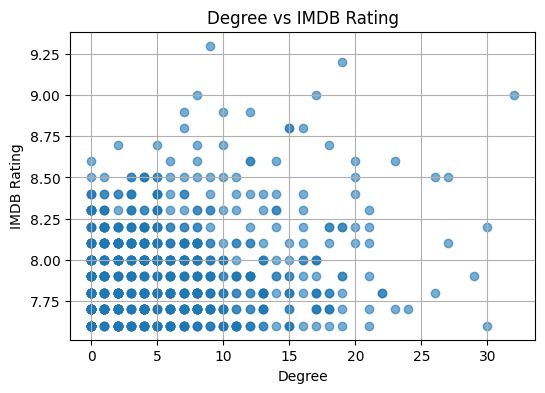

In [ ]:
# Antag G er din graf, og hver node har en attribut 'imdb_rating'
# fx: G.nodes[123]['imdb_rating'] = 7.5

# Hent data
degrees = dict(G.degree())  # {node: degree}
ratings = nx.get_node_attributes(G, 'imdb_rating')  # {node: rating}

# Sørg for at kun tage noder med ratings
nodes_with_ratings = [n for n in G.nodes if n in ratings]

deg_values = [degrees[n] for n in nodes_with_ratings]
rating_values = [ratings[n] for n in nodes_with_ratings]

# Plot
plt.figure(figsize=(6,4))
plt.scatter(deg_values, rating_values, alpha=0.6)
plt.xlabel("Degree")
plt.ylabel("IMDB Rating")
plt.title("Degree vs IMDB Rating")
plt.grid(True)
plt.show()


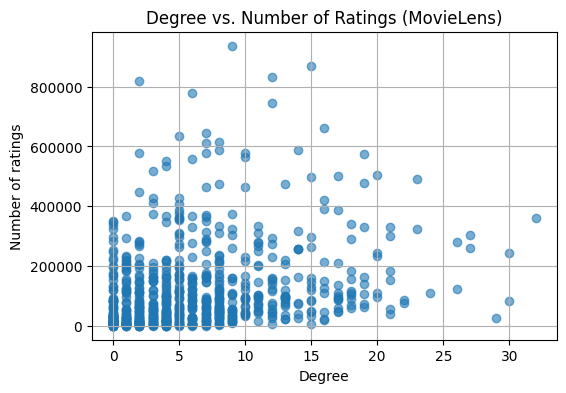

In [ ]:

# Get node degrees
degrees = dict(G.degree())

# Get number of ratings per node (length of the list)
num_ratings = {n: len(ratings_list) 
               for n, ratings_list in nx.get_node_attributes(G, 'gl_user_id_ratings').items()}

# Only nodes with ratings
nodes_with_ratings = [n for n in G.nodes if n in num_ratings]

deg_values = [degrees[n] for n in nodes_with_ratings]
rating_counts = [num_ratings[n] for n in nodes_with_ratings]

# Scatter plot
plt.figure(figsize=(6,4))
plt.scatter(deg_values, rating_counts, alpha=0.6)
plt.xlabel("Degree")
plt.ylabel("Number of ratings")
plt.title("Degree vs. Number of Ratings (MovieLens)")
plt.grid(True)
plt.show()


# Statisticks for alternetive graph

In [166]:
degree_centrality = nx.degree_centrality(G_rating)
betweenness_centrality = nx.betweenness_centrality(G_rating)
eigenvector_centrality = nx.eigenvector_centrality(G_rating)


# Sort by value (descending), keep items as (node, value)
top10_betweenness = sorted(betweenness_centrality.items(), 
                           key=lambda x: x[1], 
                           reverse=True)[:10]

print("Top 10 betweenness centrality:")
for node, val in top10_betweenness:
    print(node, val)

print()

top10_eigenvector = sorted(eigenvector_centrality.items(), 
                           key=lambda x: x[1], 
                           reverse=True)[:10]

print("Top 10 eigenvector centrality:")
for node, val in top10_eigenvector:
    print(node, val)

Top 10 betweenness centrality:
The Shawshank Redemption 0.010039419792229875
3 Idiots 0.005873004939591511
The Dark Knight 0.005835419523886378
Inception 0.003841500962384487
Fight Club 0.0034816648747747272
The Matrix 0.003415889744719777
The Godfather 0.0027902854986483093
Pulp Fiction 0.0027825999816575736
Forrest Gump 0.0027316435242457837
Schindler's List 0.0026037791605234956

Top 10 eigenvector centrality:
The Shawshank Redemption 0.04828138645918395
The Lord of the Rings: The Fellowship of the Ring 0.04826180271639316
Pulp Fiction 0.048259761468289725
The Lord of the Rings: The Two Towers 0.04825656884982552
The Godfather 0.04825639106358815
Fight Club 0.04825357238680654
The Matrix 0.048253441224036464
Schindler's List 0.04825066446984735
The Silence of the Lambs 0.04824306342183726
Star Wars 0.048223273745965294
